In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import h5py

In [3]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [4]:
def d_sigmoid(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [5]:
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

In [6]:
def d_relu(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    
    return dZ

In [24]:
def init_params(layers):
    
    np.random.seed(2)
    
    params = {}
    
    L = len(layers)
    
    for l in range(1,L):
        params['W' + str(l)] = np.random.randn(layers[l], layers[l-1]) / np.sqrt((layers[l-1])) #He initialization
        
        params['b' + str(l)] = np.zeros((layers[l], 1))
        
    return params

In [25]:
def forward_prop(X, params, activations):
    L = len(params) // 2
    caches = []
    A = X
    for l in range(L):
        A_prev = A
        A, cache = linear_activation_forward(l+1, A_prev, params['W'+str(l+1)], params['b'+str(l+1)], activations[l+1]) 
        caches.append(cache)    
    return A, caches

In [26]:
def linear_activation_forward(l, A, W, b, activation):
    linear_cache = {}
    activation_cache = {}
    Z, linear_cache = linear_forward(A, W, b)
    
    if activation == 'relu':
        A, activation_cache = relu(Z)
    
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)     
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [27]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A,W,b)
    return Z, cache

In [28]:
def calc_cost(A, y):
    m = y.shape[1]
    cost = -(1/m) * np.sum(np.dot(y, np.log(A).T) + np.dot((1-y), np.log(1-A).T))

    return cost

In [29]:
def back_prop(A, y, cache, activations):
    L = len(cache)
    grads = {}
    dAL = -(np.divide(y, A)  - np.divide((1-y), (1-A)))
    
    current_cache = cache[L-1]
    
    grads['dA'+str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = linear_activation_back(dAL, current_cache, activations[L])
            
    
    for l in reversed(range(L-1)):
        current_cache = cache[l]
        grads['dA'+str(l)], grads['dW'+str(l+1)], grads['db'+str(l+1)] = linear_activation_back(grads['dA'+str(l+1)], current_cache, activations[l+1])
        
    
    return grads

In [30]:
def linear_activation_back(dA, cache, activation):
    
    if activation == 'relu':
        dZ = d_relu(dA, cache[1])
    elif activation == 'sigmoid':
        dZ = d_sigmoid(dA, cache[1])    
    
    dA_prev, dW, db = linear_back(dZ, cache[0])
    
    return dA_prev, dW, db
    

In [31]:
def linear_back(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ) 
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    
    return dA_prev, dW, db

In [32]:
def update_params(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate*grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate*grads['db'+str(l)]
    return parameters

In [33]:
def predict(x_test, params, activations):
    L = len(params) // 2
    A, cache = forward_prop(x_test, params, activations)
    
    predictions = (A >= 0.5).astype(int)
    
    return predictions

In [34]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    y = y.reshape(y.shape[1])
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

In [35]:
def accuracy(predictions, y_test):
    x = (np.abs(predictions - y_test)).sum()
    acc = 100 - ((x/y_test.shape[1]) * 100)
    return str(acc) + "%"

In [36]:
def nn_model(X, Y, learning_rate, num_iterations, layers, activation_functions):
    params = init_params(layers)
    for i in range(num_iterations):
        AL, caches = forward_prop(X, params, activation_functions)
        cost = calc_cost(AL, Y)
        if(i%100 == 0):
            print(cost)
        grads = back_prop(AL, Y, caches, activations)    
        params = update_params(params, grads, learning_rate)
        
    return params

In [37]:
dataset = make_moons(n_samples = 5000, noise=0.1, random_state=0)
# dataset = make_circles(n_samples=100, shuffle=True, noise=None, random_state=None, factor=0.8)

X = dataset[0]
Y = dataset[1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3)

y_test = y_test.reshape(1, y_test.shape[0])
y_train = y_train.reshape(1, y_train.shape[0])

X_train = X_train.T
X_test = X_test.T

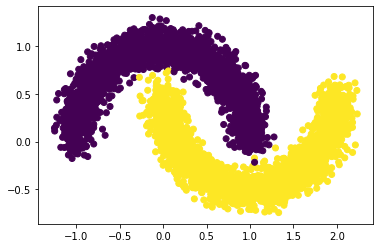

In [38]:
X, Y = dataset
X, Y = X.T, Y.reshape(Y.shape[0])

# Visualize the data
plt.scatter(X[0, :], X[1, :], c = Y);

In [39]:
layers = [2, 15, 12, 12, 1]
activations = ['none','relu','relu','relu', 'sigmoid']

In [40]:
params = nn_model(X_train, y_train, 0.7, 2500, layers, activations)

0.6841671904276313
0.027755173625401152
0.005561599634740926
0.0034871222009977216
0.0027310740027799993
0.0023327892950195227
0.0020819078271454867
0.0018928083847069403
0.0017546631252062862
0.0016500714634612467
0.0015674520122832343
0.0015004929360035453
0.0014448463238387417
0.001398197135823
0.001358225794144998
0.0013239505818103496
0.001294191600675305
0.0012678862874189363
0.0012446272054998499
0.0012239815432399672
0.001205370319158373
0.0011886620531599596
0.0011732871871217695
0.00115929936317524
0.0011465026304029232


In [41]:
predictions = predict(X_test, params, activations)

In [42]:
predictions.shape

(1, 1500)

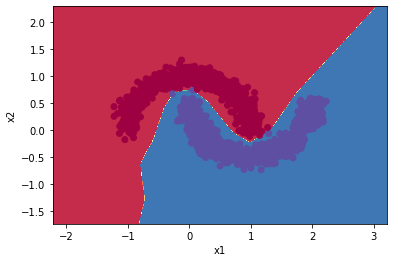

In [43]:
plot_decision_boundary(lambda x: predict(x.T, params, activations), X_test, y_test)

In [44]:
accuracy(predictions, y_test)

'99.86666666666666%'

## Load cat dataset

In [81]:
file_name = 'train_catvnoncat.h5'

In [82]:
with h5py.File(file_name, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    b_group_key = list(f.keys())[1]
    c_group_key = list(f.keys())[2]
    a_group_key = list(f.keys())[0]

    # Get the data
    x_train = list(f[b_group_key])
    y_train = list(f[c_group_key])
    labels = list(f[a_group_key])

Keys: <KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


In [83]:
X_train  = np.array(x_train)
Y_train  = np.array(y_train)

In [84]:
X_train = X_train.reshape((X_train.shape[0], -1)).T
Y_train = Y_train.reshape((Y_train.shape[0],1)).T

In [85]:
X_train = X_train / 255
Y_train = Y_train

In [86]:
X_train.shape


(12288, 209)

In [87]:
Y_train.shape


(1, 209)

In [88]:
file_name = 'test_catvnoncat.h5'


In [89]:
with h5py.File(file_name, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    b_group_key = list(f.keys())[1]
    c_group_key = list(f.keys())[2]
    a_group_key = list(f.keys())[0]

    # Get the data
    x_test = list(f[b_group_key])
    y_test = list(f[c_group_key])
    labels_test = list(f[a_group_key])

Keys: <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>


In [90]:
X_test = np.array(x_test)
Y_test = np.array(y_test)

In [91]:
X_test = X_test.reshape((X_test.shape[0], -1)).T
Y_test = Y_test.reshape((Y_test.shape[0],1)).T

In [92]:

X_test = X_test / 255
Y_test = Y_test

In [93]:
X_test.shape


(12288, 50)

In [94]:
Y_test.shape

(1, 50)

In [105]:
layers = [X_train.shape[0], 21, 8, 6, 1]
activations = ['input', 'relu','relu', 'relu', 'sigmoid']

In [106]:
params = nn_model(X_train, Y_train, 0.009,3000,layers,activations)

0.696184714196256
0.4975268799275994
0.44759271393877487
0.4198221206700482
0.271354406247393
0.1315008677433774
0.06766814624446418
0.04296505145636661
0.029281335161270416
0.021703818498443626
0.016788154471490152
0.013395759365287956
0.010954896586167124
0.009130124682992319
0.007749784937649744
0.006679692236162815
0.005835774488197313
0.0051511104401785485
0.004588057852208598
0.004121336965489163
0.003726649604045915
0.003391008937861298
0.0031086884376233964
0.0028602095876282207
0.0026455937235970303
0.0024556484029884256
0.00229345979456395
0.0021459577482581004
0.0020163440995998234
0.001897789562786599


In [107]:
predictions = predict(X_test, params, activations)

In [108]:
accuracy(predictions, Y_test)

'82.0%'

In [109]:
predictions

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0]])

In [110]:
Y_test

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])